##                                          EDA

In [1]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 41.9 MB/s eta 0:00:0000:01


In [2]:
#importing libraries
import numpy as np
import pandas as pd 
import os
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from keras.layers import *
import warnings
warnings.filterwarnings("ignore")

2024-04-23 10:40:10.283739: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 10:40:10.283932: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 10:40:10.433863: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
#Reading the datasets
PATH_CSV = '/kaggle/input/demand-forecasting-with-tabular-textual-images/beach_demand_forecast/'

df_sales = pd.read_csv(os.path.join(PATH_CSV,"sales_train.csv"))
df_items = pd.read_csv(os.path.join(PATH_CSV,"items.csv"))
df_resturant = pd.read_csv(os.path.join(PATH_CSV,"resturants.csv"))

In [4]:
# Convert the 'date' column to datetime format, handling any errors by converting them to NaT
df_sales.date = pd.to_datetime(df_sales.date, errors='coerce')

# Create a new column 'weekday' containing the name of the weekday for each date
df_sales['weekday'] = df_sales.date.dt.day_name()

# Find the minimum date in the dataset
start_date = df_sales.date.min()

# Calculate the week number for each date relative to the minimum date
# This is achieved by calculating the number of days between each date and the start date,
# dividing this number by 7 to get the number of weeks, and converting the result to an integer
df_sales['week'] = (((df_sales.date - start_date).dt.days) / 7).astype(int)

In [5]:
df_plot = df_sales[['date','item_count']].groupby(['date']).sum().reset_index()
fig = px.line(df_plot, x="date", y="item_count", title='Total Sales by Date')
fig.show()

In [6]:
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Obtain data aggregated by weekday.
df_plot = df_sales[['weekday','item_count']].groupby(['weekday']).sum().reset_index()
# Sort by day of week
df_plot = df_plot.set_index("weekday").loc[day_order].reset_index()

fig = px.bar(df_plot, x='weekday', y='item_count', title='Total Sales by Day of Week')
fig.show()

### Top Items Sold

In [5]:
df2 = df_sales[['item_id','item_count']].groupby(['item_id']).sum().reset_index().sort_values('item_count',ascending=False)
df_items2 = df_items[['id','name']]
df_items2.columns = ['item_id','name']
df_popular = df2.merge(df_items2)
print(df_popular.to_string())

    item_id  item_count                                                  name
0        19    236337.0                                    Strawberry Smoothy
1        16    102990.0                                  Frozen Milky Smoothy
2        76     61043.0                                    Amazing pork lunch
3        38     52772.0                                         Mutton Dinner
4         9     43874.0                                          Orange Juice
5        59     42774.0                               Blue Ribbon Beef Entree
6         4     34439.0                       Amazing Steak Dinner with Rolls
7        13     27490.0                               Sweet Frozen Soft Drink
8        56     23839.0                       Sea Bass with Vegetables Dinner
9        67     18764.0                                       Sweet Lamb Cake
10       21     13190.0                     Amazing Fish with Vegetables Meal
11       12      7791.0                                  Fantast

In [6]:
df_popular.groupby('name').agg({'item_id': list, 'item_count': 'sum'}).reset_index().sort_values('item_count',ascending=False)[:10]


,name,item_id,item_count
85,Strawberry Smoothy,[19],236337.0
46,Frozen Milky Smoothy,"[16, 71]",103263.0
9,Amazing pork lunch,[76],61043.0
64,Mutton Dinner,[38],52772.0
67,Orange Juice,[9],43874.0
22,Blue Ribbon Beef Entree,[59],42774.0
4,Amazing Steak Dinner with Rolls,[4],34439.0
88,Sweet Frozen Soft Drink,[13],27490.0
83,Sea Bass with Vegetables Dinner,[56],23839.0
90,Sweet Lamb Cake,[67],18764.0


### Analyzing the data by a single year

In [9]:
SINGLE_YEAR = 2020

df_sales_single_year = df_sales[df_sales['date'].dt.year == SINGLE_YEAR]
df_sales_single_year = df_sales_single_year[df_sales_single_year['item_id'].isin([19,16,71,76,38,9,59,4,13,56,67])]
df_plot = df_sales_single_year[['date','item_id','item_count']].groupby(['date','item_id']).sum().reset_index()
df_plot = df_plot.merge(df_items,left_on="item_id",right_on="id")[['date','item_count','name']]
fig = px.bar(df_plot, x='date', y='item_count',color="name", title=f'Item Sales by Date - {SINGLE_YEAR}')
fig.update_layout(bargap=0.0,bargroupgap=0.0)
fig.show()

In [10]:
df_plot = df_sales_single_year[['week','item_id','item_count']].groupby(['week','item_id']).sum().reset_index()
df_plot = df_plot.merge(df_items,left_on="item_id",right_on="id")[['week','item_count','name']]
fig = px.bar(df_plot, x='week', y='item_count',color="name", title=f'Total Sales by Week - {SINGLE_YEAR}')
fig.update_layout(bargap=0.0,bargroupgap=0.0)
fig.show()

### Seperating sales data of different items an dplotting it

In [6]:
Strawberry_Smoothy_df = df_sales[df_sales['item_id'].isin([19])][['date','item_count']]
Amazing_pork_lunch_df = df_sales[df_sales['item_id'].isin([76])][['date','item_count']]
Blue_Ribbon_Beef_Entree_df = df_sales[df_sales['item_id'].isin([59])][['date','item_count']]
Sweet_Lamb_Cake_df = df_sales[df_sales['item_id'].isin([67])][['date','item_count']]
Amazing_Steak_Dinner_with_Rolls_df = df_sales[df_sales['item_id'].isin([4])][['date','item_count']]

In [7]:
dfs=[Strawberry_Smoothy_df,Amazing_pork_lunch_df,Blue_Ribbon_Beef_Entree_df,Sweet_Lamb_Cake_df,Amazing_Steak_Dinner_with_Rolls_df]
for dfi in dfs:
    fig = px.line(dfi, x='date',y='item_count',title='Total Sales by Date')
    fig.show()

In [8]:
Strawberry_Smoothy_df.reset_index(drop=True, inplace=True)
Strawberry_Smoothy_df.set_index('date', inplace=True)

Variance After Before differencing = 8427.598306216367
Variance After weekly differencing = 6641.041397107949
Variance After yearly differencing = 1866.9897038399317
Mean = -0.12016574585635359


Text(0.5, 1.0, 'Plot after removing weekly and Yearly Seasonality')

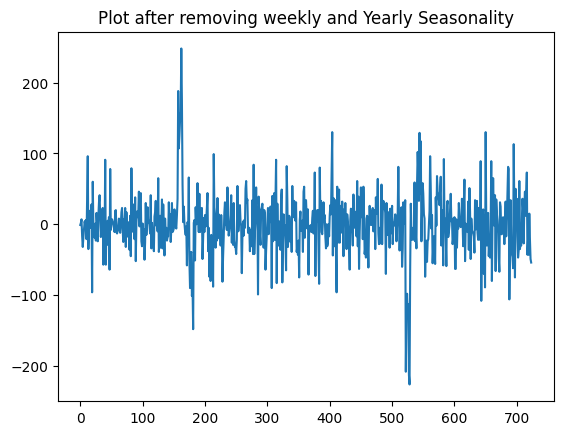

In [11]:
x= np.array(Strawberry_Smoothy_df['item_count'][365:]) - np.array(Strawberry_Smoothy_df['item_count'][:len(Strawberry_Smoothy_df)-365])
y = x[7:]-x[:len(x)-7]
print('Variance After Before differencing =',np.var(Strawberry_Smoothy_df['item_count']))
print('Variance After weekly differencing =',np.var(x))
print('Variance After yearly differencing =',np.var(y))
print('Mean =',np.mean(y))
plt.plot(y)
plt.title('Plot after removing weekly and Yearly Seasonality')

* So here clearly we can observe weekly seasonality and Yealy seasonality.

In [9]:
# Specify the size of the training set (e.g., 70% of the data)
train_size = 0.7

# Calculate the index to split the data
split_index = int(len(Strawberry_Smoothy_df) * train_size)

# Split the data into train and test sets
train_df = Strawberry_Smoothy_df.iloc[:split_index]
test_df = Strawberry_Smoothy_df.iloc[split_index:]

## Holt winter Exponential Smoothing

In [10]:
# Create and fit the Exponential Smoothing model
model = ExponentialSmoothing(train_df['item_count'], trend='add', seasonal='mul', seasonal_periods=365)
fitted_model = model.fit()

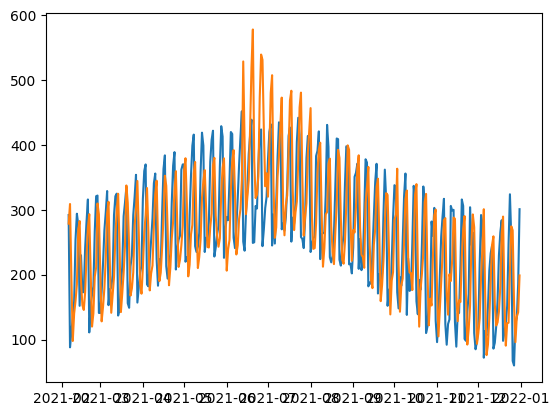

In [11]:
plt.plot(test_df)
plt.plot(fitted_model.predict(start=test_df.index[0],end = test_df.index[-1]))

In [13]:
predicted = fitted_model.predict(start=test_df.index[0],end = test_df.index[-1])

# Calculate RMSE
rmse_ex = np.sqrt(mean_squared_error(np.array(test_df['item_count']),predicted ))
print("Root Mean Squared Error (RMSE):", rmse_ex)

# Mean Absolute Error (MAE)
mae_ex = np.mean(np.abs(np.array(test_df['item_count']) - predicted))
print("Mean Absolute Error (MAE):", mae_ex)

# Mean Absolute Percentage Error (MAPE)
mape_ex = np.mean(np.abs((np.array(test_df['item_count']) - predicted) / np.array(test_df['item_count']))) * 100
print("Mean Absolute Percentage Error (MAPE):", mape_ex)

Root Mean Squared Error (RMSE): 91.43698848344836
Mean Absolute Error (MAE): 70.91168037077883
Mean Absolute Percentage Error (MAPE): 35.30909687570179


## SARIMA Model

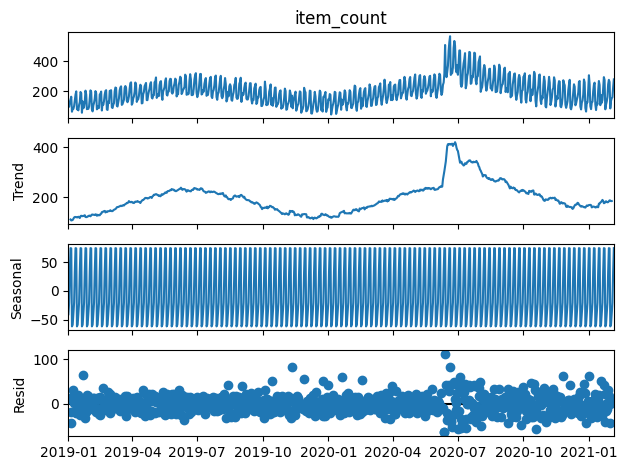

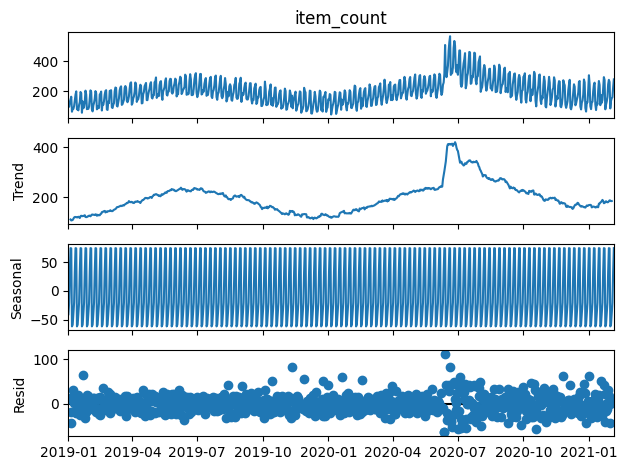

In [14]:
decomp = seasonal_decompose(train_df['item_count'])
decomp.plot()

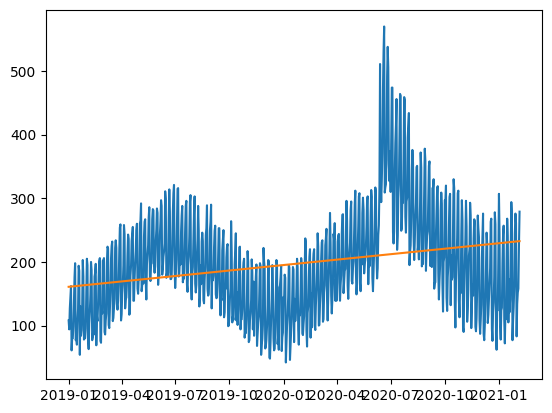

In [15]:
# Step 1: Detrending using linear regression
X = np.arange(len(train_df)).reshape(-1, 1)

trend_model = LinearRegression()
trend_model.fit(X, train_df['item_count'].values)

train_df['trend'] = trend_model.predict(X)
plt.plot(train_df['item_count'])
plt.plot(train_df['trend'])

In [16]:
train_df['detrend'] = train_df['item_count'] - train_df['trend']
train_df.index = pd.to_datetime(train_df.index)
seasonal_indices = train_df['detrend'].groupby(train_df.index.day_name()).mean()

# Convert the grouped_data Series to a DataFrame with a column name
seasonal_component_df = seasonal_indices.to_frame(name='weekly_seasonality')

# Merge the seasonal_component_df DataFrame with Strawberry_Smoothy_df on the day name
train_df = train_df.merge(seasonal_component_df, left_on=train_df.index.day_name(), right_index=True)

In [17]:
train_df['with_yearly_seasonality'] = train_df['detrend'] - train_df['weekly_seasonality']

In [18]:
train_df.drop(columns=['key_0'], inplace=True)

seasonal_indices = train_df['with_yearly_seasonality'].groupby(train_df.index.month).mean()

# Convert the grouped_data Series to a DataFrame with a column name
yearly_seasonal_component_df = seasonal_indices.to_frame(name='yearly_seasonality')

# Merge the seasonal_component_df DataFrame with Strawberry_Smoothy_df on the day name
train_df = train_df.merge(yearly_seasonal_component_df, left_on=train_df.index.month, right_index=True)

In [19]:
train_df['stationary'] = train_df['with_yearly_seasonality'] - train_df['yearly_seasonality']

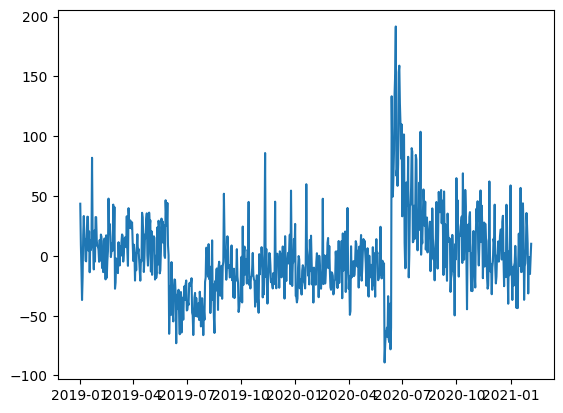

In [21]:
plt.plot(train_df['stationary'])

In [22]:
# ADF Test on Residuals
adf_result = adfuller(train_df['stationary'])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:', adf_result[4])

ADF Statistic: -3.172159911767332
p-value: 0.021653794837670402
Critical Values: {'1%': -3.439146171679794, '5%': -2.865422101274577, '10%': -2.568837245865348}


Above we observe that at 1% LOS ADF statistic is lower than the critical value So the residuals are stationary.

### Plotting ACF And PACF for the residuals

Text(0.5, 1.0, 'Partial Autocorrelation Function (ACF)')

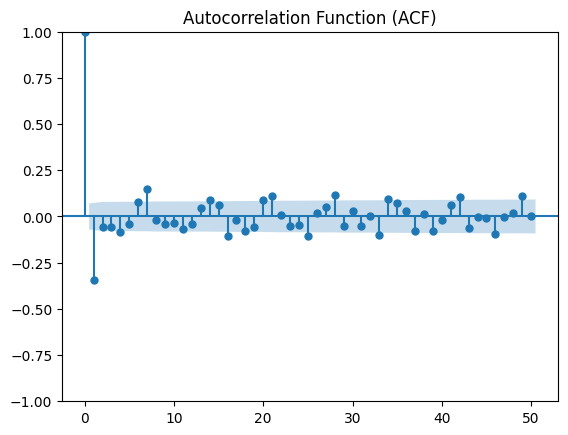

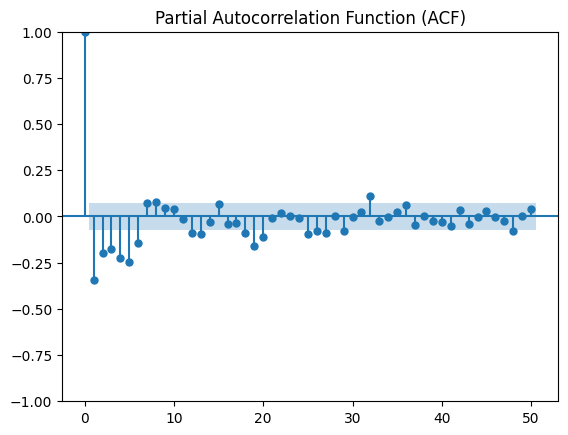

In [45]:
plot_acf(np.array(train_df['stationary'].diff().dropna()),lags=50)
plt.title('Autocorrelation Function (ACF)')

plot_pacf(np.array(train_df['stationary'].diff().dropna()),lags=50)
plt.title('Partial Autocorrelation Function (ACF)')


#### Splitting the data into train and test set

### Finding th best Seasonal ARIMA Model

In [91]:
arima_model = auto_arima(train_df['stationary'], start_p=0, start_q=0, d=1, max_p=8, max_q=8, 
                         D=1, max_order=None, m=7,start_P=0, start_Q=0, max_P=6, max_Q=6,
                         seasonal=True, information_criterion='aic', 
                         alpha=0.05, test='kpss', seasonal_test='ocsb', stepwise=True, 
                         n_jobs=1, start_params=None, trend=None, method='lbfgs', 
                         maxiter=50, offset_test_args=None, seasonal_test_args=None, 
                         suppress_warnings=True, error_action='trace', trace=False, 
                         random=False, random_state=None, n_fits=10, 
                         return_valid_fits=False, out_of_sample_size=0, 
                         scoring='mse', scoring_args=None, with_intercept='auto', 
                         sarimax_kwargs=None)
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  767
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 7)   Log Likelihood               -3472.988
Date:                           Tue, 23 Apr 2024   AIC                           6957.977
Time:                                   11:34:26   BIC                           6985.769
Sample:                               01-01-2019   HQIC                          6968.680
                                    - 02-05-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1208      0.045      2.697      0.007       0.033       0.209
ma.L1         -0.7308      0.026    -28.401      0.000      -0.781      -0.680
ar.S.L7        0.0614      0.035      1.728      0.084      -0.008       0.131
ar.S.L14      -0.0711      0.039     -1.819      0.069      -0.148       0.006
ma.S.L7       -0.8981      0.021    -43.067      0.000      -0.939      -0.857
sigma2       543.0869     12.330     44.045      0.000     518.920     567.254
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2487.01
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.76   Skew:                             1.00
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

* The Best Model parameters are :
p = 1
d = 1
q = 1
P = 2
Q = 1
D = 1
m = 7

In [102]:
model = SARIMAX(train_df['stationary'], order=(6, 1, 4), seasonal_order=(2, 1, 1, 7))

# Fit the model
results = model.fit()

# Print the summary of the fitted model
print(results.summary())

# Forecast future values
forecast = results.forecast(steps=len(test_df))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.64938D+00    |proj g|=  2.73935D-01


 This problem is unconstrained.



At iterate    5    f=  4.57209D+00    |proj g|=  6.76144D-02

At iterate   10    f=  4.54705D+00    |proj g|=  1.79406D-02

At iterate   15    f=  4.53163D+00    |proj g|=  2.88373D-02

At iterate   20    f=  4.52773D+00    |proj g|=  2.33626D-02

At iterate   25    f=  4.51564D+00    |proj g|=  2.84156D-02

At iterate   30    f=  4.50875D+00    |proj g|=  2.37952D-02

At iterate   35    f=  4.50716D+00    |proj g|=  9.27793D-03

At iterate   40    f=  4.50569D+00    |proj g|=  4.50581D-03

At iterate   45    f=  4.50500D+00    |proj g|=  3.59639D-03

At iterate   50    f=  4.50494D+00    |proj g|=  2.15104D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [24]:
test_yearly_seasonality = test_df.merge(yearly_seasonal_component_df, left_on=test_df.index.month, right_index=True)['yearly_seasonality']
test_weekly_seasonality = test_df.merge(seasonal_component_df, left_on=test_df.index.day_name(), right_index=True)['weekly_seasonality']
# Step 1: Detrending using linear regression
p = np.arange(len(train_df + test_df)).reshape(-1, 1)
trend_seasonality = test_yearly_seasonality + test_weekly_seasonality + trend_model.predict(p)[len(train_df):]

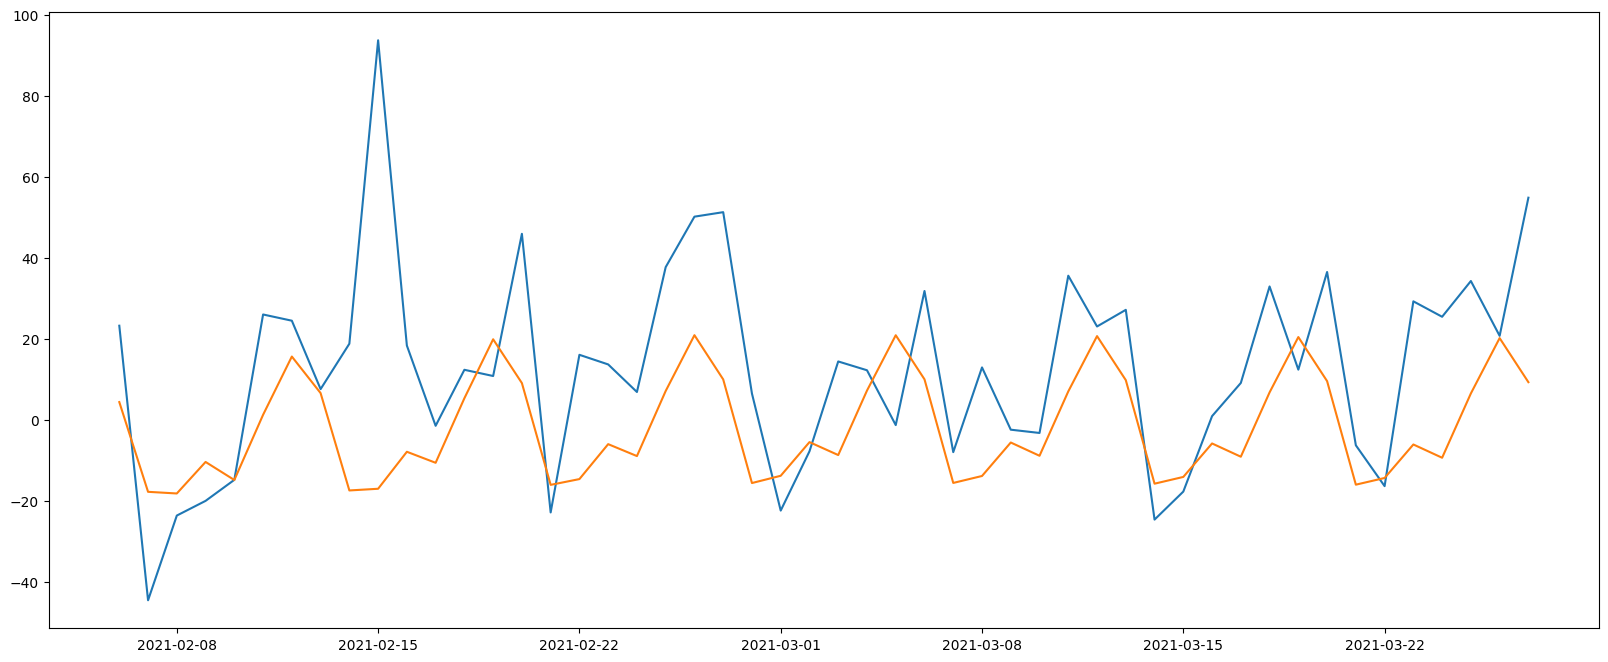

In [185]:
plt.figure(figsize=(20,8))
ac = test_df['item_count'] - trend_seasonality
plt.plot(ac[:50])
plt.plot(forecast[:50])

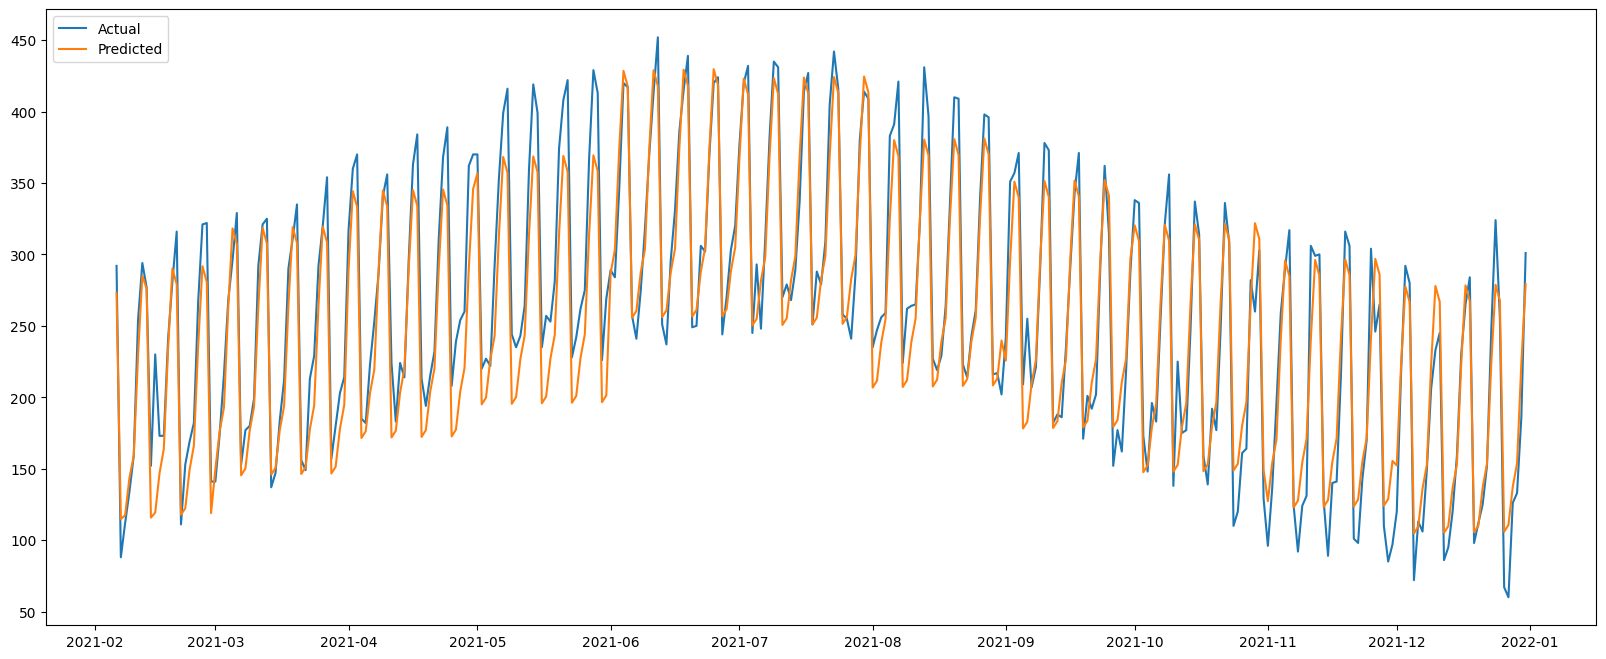

In [104]:
Y_hat = forecast + trend_seasonality
plt.figure(figsize=(20,8))
#plt.plot(train, label='Training')
plt.plot(test_df['item_count'],label='Actual')
plt.plot(Y_hat,label = 'Predicted')
plt.legend(loc = 'upper left')
plt.show()

In [105]:
# Calculate RMSE
rmse_arima = np.sqrt(mean_squared_error(np.array(test_df['item_count']),Y_hat ))
print("Root Mean Squared Error (RMSE):", rmse_arima)

# Mean Absolute Error (MAE)
mae_arima = np.mean(np.abs(np.array(test_df['item_count']) - Y_hat))
print("Mean Absolute Error (MAE):", mae_arima)

# Mean Absolute Percentage Error (MAPE)
mape_arima = np.mean(np.abs((np.array(test_df['item_count']) - Y_hat) / np.array(test_df['item_count']))) * 100
print("Mean Absolute Percentage Error (MAPE):", mape_arima)

Root Mean Squared Error (RMSE): 27.61911463647387
Mean Absolute Error (MAE): 21.791848463845824
Mean Absolute Percentage Error (MAPE): 9.81220789764074


## Prophet

In [106]:
train_fb = train_df.reset_index()[['date','item_count']].rename({'date':'ds','item_count':'y'},axis='columns')

In [107]:
model = Prophet()

# Add weekly seasonality
model.add_seasonality(name='weekly', period=7, fourier_order=2)

# Add yearly seasonality
model.add_seasonality(name='yearly', period=365.25, fourier_order=2)

model.fit(train_fb)
future = model.make_future_dataframe(periods=365)
pred = model.predict(future[len(future)-365:])

11:38:00 - cmdstanpy - INFO - Chain [1] start processing
11:38:00 - cmdstanpy - INFO - Chain [1] done processing


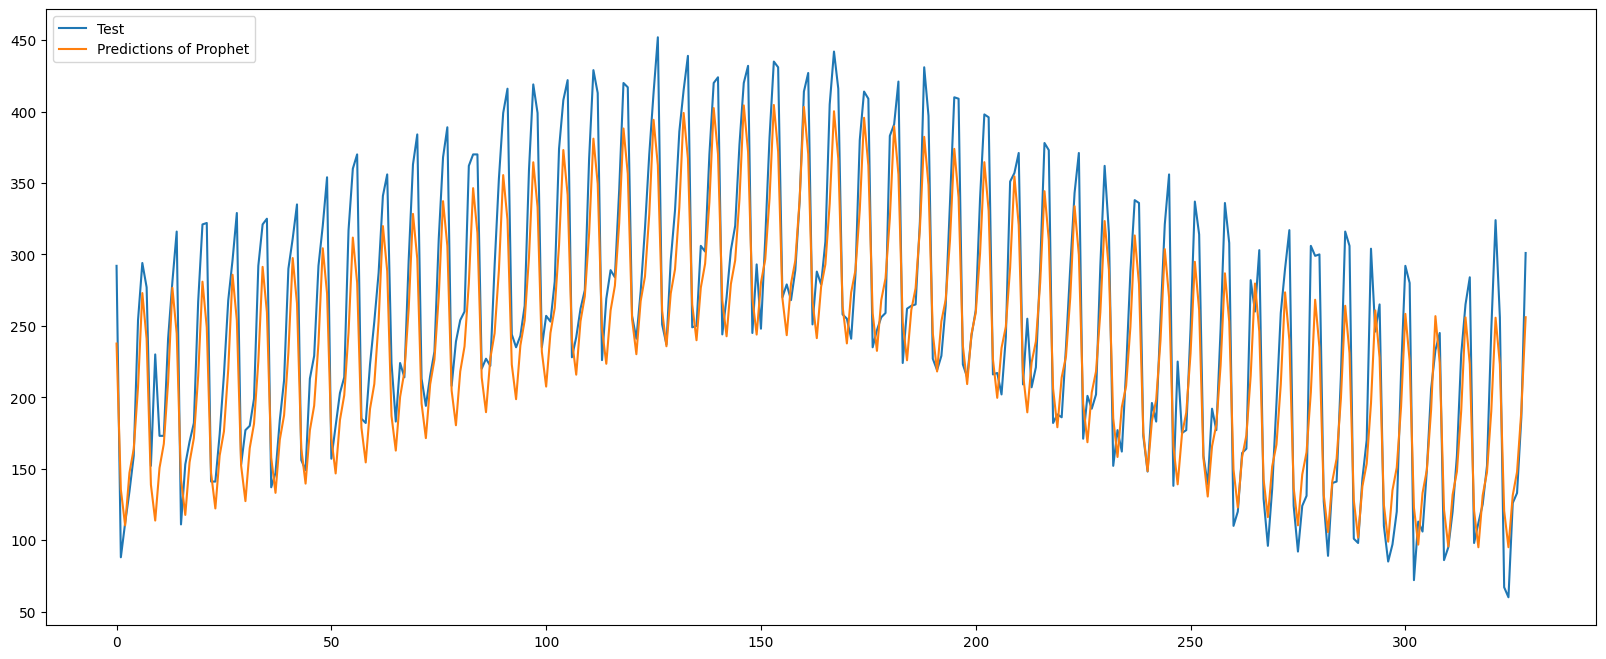

In [108]:
plt.figure(figsize=(20,8))
#plt.plot(train, label='Training')
plt.plot(np.array(test_df['item_count']), label='Test')
plt.plot(pred['yhat'][:len(test_df)], label='Predictions of Prophet')
plt.legend(loc = 'upper left')
plt.show()

In [111]:
predicted = np.array(pred['yhat'][:len(test_df)])

# Calculate RMSE
rmse_pro = np.sqrt(mean_squared_error(np.array(test_df['item_count']), predicted))
print("Root Mean Squared Error (RMSE):", rmse_pro)

# Mean Absolute Error (MAE)
mae_pro = np.mean(np.abs(np.array(test_df['item_count']) - predicted))
print("Mean Absolute Error (MAE):", mae_pro)

# Mean Absolute Percentage Error (MAPE)
mape_pro = np.mean(np.abs((np.array(test_df['item_count']) - predicted) / np.array(test_df['item_count']))) * 100
print("Mean Absolute Percentage Error (MAPE):", mape_pro)

Root Mean Squared Error (RMSE): 38.18725696652578
Mean Absolute Error (MAE): 30.308527698831345
Mean Absolute Percentage Error (MAPE): 12.048469646815184


## LSTM

In [181]:
# Define the number of input samples
n_input = 10

# Initialize lists to store input sequences and target values
X = []
y = []

# Iterate through the data to create sequences
for i in range(len(train_df['stationary'].diff().dropna()) - n_input):
    # Extract input sequence and target value
    seq_x = np.array(train_df['stationary'].diff().dropna())[i:i+n_input] # Extract first column for input sequence
    seq_y = np.array(train_df['stationary'].diff().dropna())[i+n_input]    # Extract target value from first column
    
    # Append the sequences and target values to the lists
    X.append(seq_x)
    y.append(seq_y)

# Convert lists to arrays
X = np.array(X)
y = np.array(y)

# Reshape X to match the input shape required by the model (batch_size, timesteps, features)
X = X.reshape((X.shape[0], n_input, 1))  # Assuming one feature per input sequence

print("Input sequences shape:", X.shape)
print("Target values shape:", y.shape)

Input sequences shape: (757, 10, 1)
Target values shape: (757,)


In [182]:
# Define model
model = Sequential()
model.add(InputLayer(input_shape=(n_input, 1)))
model.add(Bidirectional(LSTM(256, activation='relu', return_sequences=True)))
model.add(Bidirectional(LSTM(128, activation='relu', return_sequences=True)))
model.add(Bidirectional(LSTM(50, activation='relu')))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_14                │ (None, 10, 512)        │       528,384 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ (None, 10, 256)        │       656,384 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_16                │ (None, 100)            │       122,800 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,307,669 (4.99 MB)

 Trainable params: 1,307,669 (4.99 MB)

 Non-trainable params: 0 (0.00 B)

In [183]:
# fit model
model.fit(X,y,epochs=90, verbose = 0)

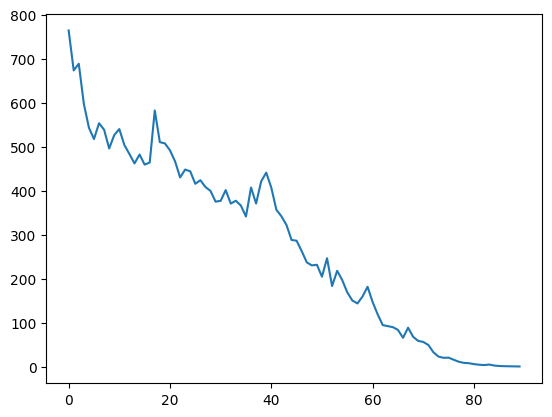

In [173]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [174]:
test_predictions = []

first_eval_batch = X[-1]
current_batch = first_eval_batch.reshape((1, n_input, 1))

for i in range(len(test_df)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch, verbose=0)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

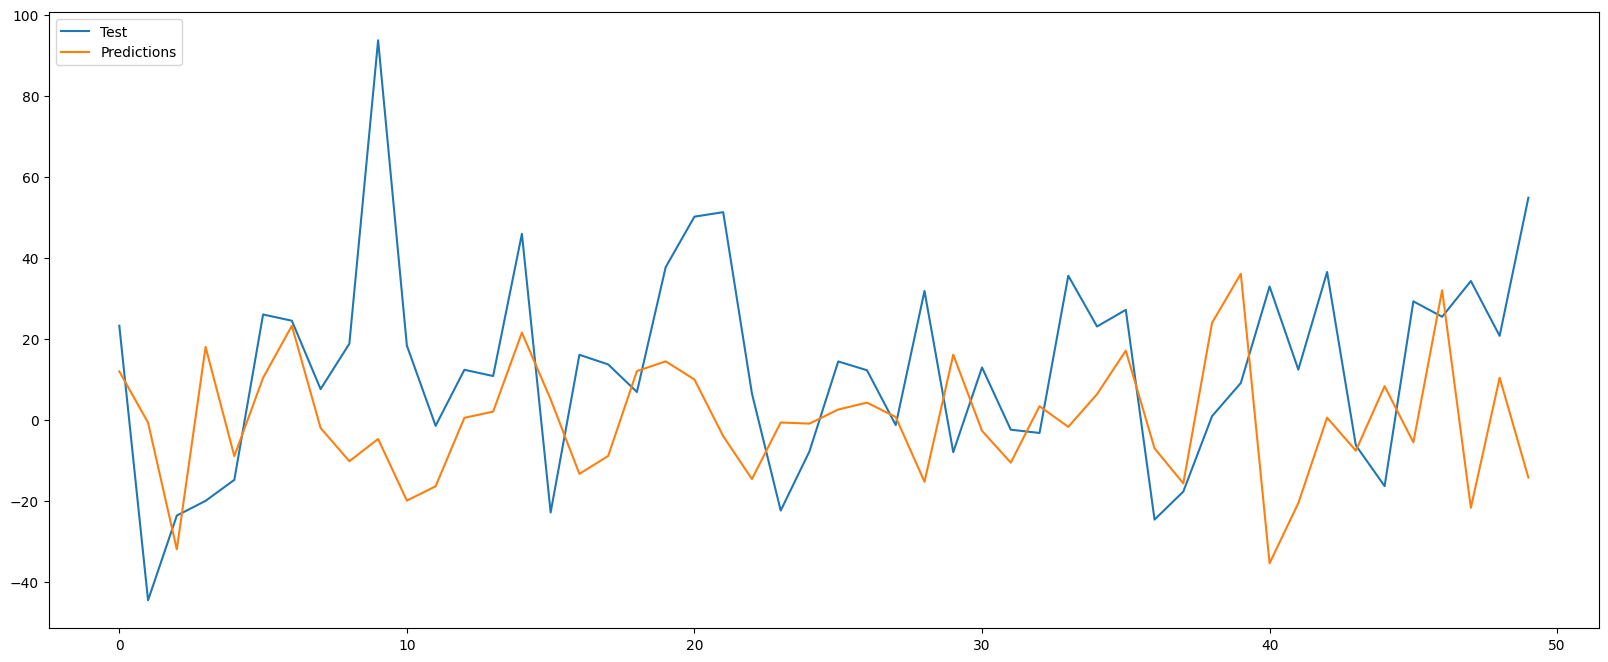

In [180]:
plt.figure(figsize=(20,8))
#plt.plot(train, label='Training')
plt.plot(np.array(ac[:50]), label='Test')
plt.plot(test_predictions[:50], label='Predictions')
plt.legend(loc = 'upper left')
plt.show()

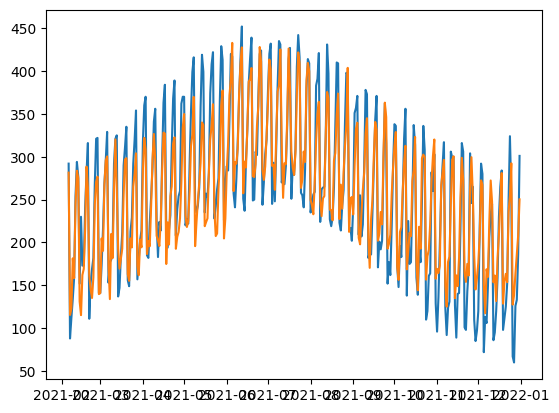

In [159]:
Y_hat = np.array(test_predictions).flatten() + trend_seasonality
plt.plot(test_df['item_count'])
plt.plot(Y_hat)

In [160]:
# Calculate RMSE
rmse_lstm = np.sqrt(mean_squared_error(np.array(test_df['item_count']),Y_hat ))
print("Root Mean Squared Error (RMSE):", rmse_lstm)

# Mean Absolute Error (MAE)
mae_lstm = np.mean(np.abs(np.array(test_df['item_count']) - Y_hat))
print("Mean Absolute Error (MAE):", mae_lstm)

# Mean Absolute Percentage Error (MAPE)
mape_lstm = np.mean(np.abs((np.array(test_df['item_count']) - Y_hat) / np.array(test_df['item_count']))) * 100
print("Mean Absolute Percentage Error (MAPE):", mape_lstm)

Root Mean Squared Error (RMSE): 34.8119713851908
Mean Absolute Error (MAE): 27.76407859313079
Mean Absolute Percentage Error (MAPE): 13.627132310228296


In [179]:
data = {
    "Model": ["Holt Winter Exponential Smoothing", "PROPHET","LSTM", "SARIMA"],
    "RMSE": [rmse_ex,rmse_pro,rmse_lstm,rmse_arima],
    "MAE": [mae_ex,mae_pro,mae_lstm,mae_arima],
    "MAPE": [mape_ex,mape_pro,mape_lstm,mape_arima]
}
EM  = pd.DataFrame(data)
EM.set_index('Model', inplace=True)
EM

,RMSE,MAE,MAPE
Model,,,
Holt Winter Exponential Smoothing,91.436988,70.911680,35.309097
PROPHET,38.187257,30.308528,12.048470
LSTM,34.811971,27.764079,13.627132
SARIMA,27.619115,21.791848,9.812208
